In [ ]:
!apt-get install tshark
!pip install pyshark

!tshark -r "test.pcap" -R "wlan.fc.type_subtype == 0x04" -2 -T fields -e frame.number -e frame.time -e wlan.sa -e wlan.da -e wlan_radio.signal_dbm -e wlan.ssid -E header=y -E separator=, -E quote=d -E occurrence=f > capture.csv

In [ ]:
import pandas as pd
df = pd.read_csv('capture.csv')
df = df[df['wlan.sa'].notna()]
df.head()

,frame.number,frame.time,wlan.sa,wlan.da,wlan_radio.signal_dbm,wlan.ssid
0,1,"Mar 21, 2023 14:25:38.756341000 UTC",96:68:b7:b8:6d:86,ff:ff:ff:ff:ff:ff,-76,NaN
1,2,"Mar 21, 2023 14:25:38.766284000 UTC",fa:45:91:c9:4b:5f,ff:ff:ff:ff:ff:ff,-81,NaN
2,3,"Mar 21, 2023 14:25:39.227641000 UTC",b0:10:41:ec:71:cb,ff:ff:ff:ff:ff:ff,-68,ABOLFAZL
3,4,"Mar 21, 2023 14:25:39.229578000 UTC",b0:10:41:ec:71:cb,ff:ff:ff:ff:ff:ff,-69,NaN
4,5,"Mar 21, 2023 14:25:39.262615000 UTC",b0:10:41:ec:71:cb,ff:ff:ff:ff:ff:ff,-67,ABOLFAZL


In [ ]:
unique_sa = pd.unique(df['wlan.sa'])
print('There were ' +str(len(unique_sa)) + ' source MAC addresses')

There were 820 source MAC addresses


In [ ]:
#The 'local bit' is the second last bit in the first byte of the MAC
#address. So, masking the first byte with '00000010' mask will return 
#the value of this local bit. if local bit is '1' then address is randomized.

def is_local_mac(sa):
    first_octet = '0x'  + sa[0:2] #take the first octet of the MAC address (first two exadecimal values)
    first_octet = int(format(int(first_octet,16),'08b'),2) #transform the first octet in binary format over 8 bits
    mask = int(format(2,'08b'),2) #create the mask 00000010 (it's number 2 in decimal format)
    if(mask & first_octet == mask): #perform bitwise and and check if it's equal to mask
      return True
    else:
      return False

df2 = df[df['wlan.sa'].notna()]
df2['is_local'] = df2['wlan.sa'].apply(lambda x : is_local_mac(x))
df2.head()

print('There were only ' + str(len(df2[df2['is_local']==False])) + ' real MAC addresses')
df_real = df2[df2['is_local']==False]
unique_sa_real = pd.unique(df_real['wlan.sa'])


There were only 208 real MAC addresses


In [ ]:
df_sa = df2.groupby(['wlan.sa'])
MEAN_RSSI = []
MEAN_IAT = []
for sa, probes in df_sa:
  ssids = pd.unique(probes['wlan.ssid'])
  rssi = probes['wlan_radio.signal_dbm'].astype(float).mean()
  iat = pd.to_datetime(probes['frame.time']).diff(1).dt.total_seconds().mean()
  if(len(probes)>10):
    print(sa, rssi, ssids, iat)
    MEAN_RSSI.append(rssi)
    MEAN_IAT.append(iat)

0e:28:88:b5:49:cc -75.5 ['TP-Link_' 'koorosh' nan] 0.012707363636363635
26:d9:49:1e:8e:67 -77.78571428571429 ['polimi' nan 'FASTWEB-577AFY' 'EOLO_DE_NONI' 'VITRUVIA�������'
 'VITRUVIANI.5Ghz'] 14.640190230769228
2a:f3:78:aa:9e:3b -61.0 ['TP-Link_' 'koorosh' nan] 0.017795769230769233
36:b6:c5:fb:dc:8a -68.75 ['TP-Link_' 'koorosh' nan] 0.01218018181818182
40:1c:83:a6:f9:41 -58.15384615384615 [nan 'polimi'] 13.097276166666667
4a:2e:8e:47:9f:0a -76.46153846153847 ['TP-Link_' 'koorosh' nan] 0.01276725
52:03:80:1a:29:9f -79.91666666666667 ['TP-Link_' 'koorosh' nan] 0.0077240909090909105
56:e3:19:7e:f8:6b -73.54545454545455 ['TP-Link_' 'koorosh' nan] 0.012515300000000004
5e:c7:65:92:94:87 -73.75 ['TP-Link_' 'koorosh' nan] 0.011669909090909092
62:f6:da:47:63:1d -69.75 ['koorosh' nan 'TP-Link_'] 0.015194000000000001
66:14:51:c5:d0:cc -74.36363636363636 [nan 'TP-Link_' 'koorosh'] 0.014252400000000002
66:52:87:cb:bd:26 -72.9090909090909 ['TP-Link_' 'koorosh' nan] 0.015613200000000002
7e:7d:6a:06:

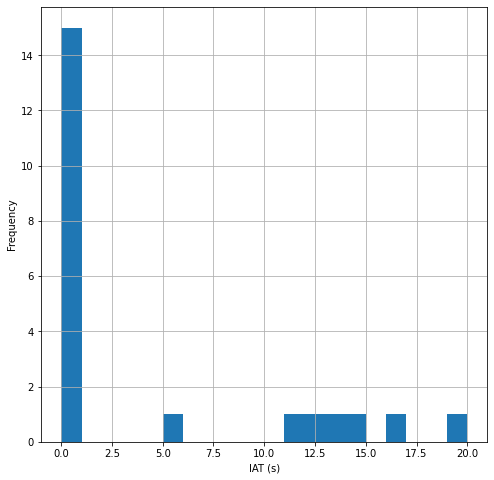

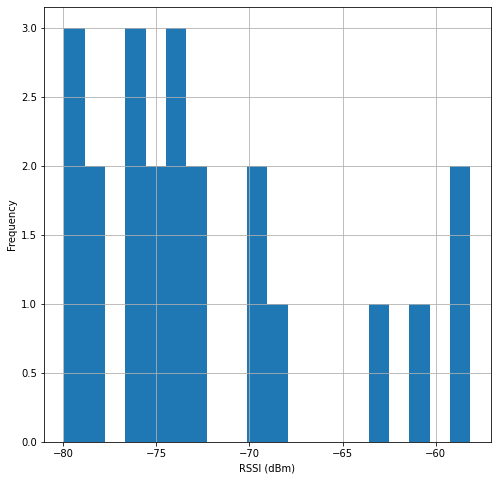

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8));
plt.hist(MEAN_IAT, 20, density=False);
plt.grid(visible=True);
plt.xlabel('IAT (s)');
plt.ylabel('Frequency');

fig = plt.figure(figsize=(8,8));
plt.hist(MEAN_RSSI, 20, density=False);
plt.grid(visible=True);
plt.xlabel('RSSI (dBm)');
plt.ylabel('Frequency');


In [ ]:
import requests
import json

SSIDs = ['iphone di virginia', 'baia di ponente',
 'SRBRING GUEST', 'ipad della prof', 'STBRING GUEST', 'Baia di Ponente',
 'BAIA DI PONENTE']
 
SSIDs = ['polimi', 'FASTWEB-577AFY', 'EOLO_DE_NONI',
 'VITRUVIANI.5Ghz']
 
for ssid in SSIDs:
  query = 'https://api.wigle.net/api/v2/network/search?onlymine=false&freenet=false&paynet=false&ssid=' + ssid
  response = requests.get(query, auth=('xxx', 'xxx'), headers={'Accept': 'application/json'})
  res = json.loads(response.content)
  if res['totalResults']>0:
    print(ssid + ': ' +res['results'][0]['region'], res['results'][0]['postalcode'], res['results'][0]['trilat'], res['results'][0]['trilong'])

polimi: Lombardia 20133 45.47920609 9.23057747
FASTWEB-577AFY: Lombardia 20124 45.48051453 9.20987606
VITRUVIANI.5Ghz: Lombardia 20124 45.48051453 9.20987606


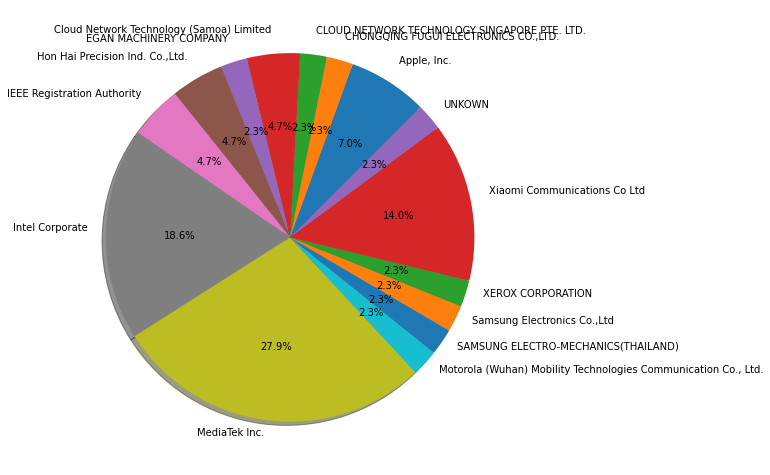

In [ ]:
import itertools

f = open('standards-oui.ieee.org.txt','r')
vendor_mac = []
vendor_name = []
for line in f:
    if "(base 16)" in line:
        fields = line.split("\t")
        vendor_mac.append(fields[0][0:6])
        vendor_name.append(fields[2])
UNIQUE_VENDOR = np.unique(vendor_name)
UNIQUE_VENDOR = np.append(UNIQUE_VENDOR,"UNKOWN")
VENDOR_HIST = [0]*len(UNIQUE_VENDOR)


for sa in unique_sa:
  red_mac = sa[0:8].upper()
  red_mac = red_mac.replace(':','')
  #get the corresponding vendor or unkown
  try:
    index = vendor_mac.index(red_mac)
  except ValueError:
    index = -1
  #increment the corresponding bin
  if index!=-1:
    v_name = vendor_name[index]
    vendor_idx = np.where(UNIQUE_VENDOR==v_name)
    vendor_idx = vendor_idx[0]
    VENDOR_HIST[vendor_idx[0]]  = VENDOR_HIST[vendor_idx[0]] + 1
  else:
    VENDOR_HIST[len(VENDOR_HIST)-1] = 0
    VENDOR_HIST[len(VENDOR_HIST)-1] = VENDOR_HIST[len(VENDOR_HIST)-1] + 1

selectors = [x>0 for x in VENDOR_HIST]
red_vendor_hist = list(itertools.compress(VENDOR_HIST,selectors)) 
vendor_labels = list(itertools.compress(UNIQUE_VENDOR,selectors))

pasd = plt.figure(figsize=(8,8));
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
plt.pie(red_vendor_hist,labels = vendor_labels, autopct='%1.1f%%', shadow=True, startangle=45)
plt.show()